# Deep mutational scanning of Perth/2009 (H3N2) HA

## Overview

We performed deep mutational scanning of **hemagglutinin (HA)** from the **A/Perth/16/2009(H3N2)** influenza virus strain. This is analysis of the data generated from the DMS experiments using the [`dms_tools2`](https://github.com/jbloomlab/dms_tools2) software.

## Experimental summary

The goal of these experiments was to measure the effect of all possible single amino-acid mutations to HA on viral replication in cell culture. We created triplicate codon-mutant libraries of the Perth/2009 H3 HA, rescued virus libraries using the helper virus approach described in [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155), and passaged the generated mutant virus libraries at low multiplicity of infection (MOI) in cell culture to select for functional variants of HA.

For each library, there is a _mutDNA-#_ sample representing the plasmid mutant library, and a _mutvirus-#_ sample representing the mutant viruses after passaging. Note that library 3 was passaged in technical replicate, so there are two _mutvirus_ samples (_3-1_ and _3-2_) for library 3. There is also a single set of wild-type controls for the unmutated plasmid and the corresponding virus, referred to as _wtDNA_ and _wtvirus_.

As described previously, all of the plasmid and virus samples were deep sequenced using a barcoded-subamplicon sequencing approach to reduce the standard Illumina sequencing error rate.

## Goals

In this analysis, we will try to achieve the following goals:
1. Infer the site-specific amino-acid preferences for H3 and use these preferences to improve the phylogenetic fit of natural H3 sequences
2. Determine if the preferences reveal lineage-specific patterns in mutational effects in human H3N2 evolution
3. Investigate the extent of mutational shifts between two diverged HA homologs

# Section 1: Infer H3 site-specific amino-acid preferences

## Import modules, define directories

In [23]:
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import io
import scipy
import pickle
import Bio
import Bio.Phylo
import gzip
import json
import dms_tools2
import dms_tools2.plot
import dms_tools2.dssp
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore') # don't print warnings to avoid clutter in notebook
from IPython.display import display, HTML, Markdown
# from pymodules.utils import * # custom modules for this analysis

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

resultsdir = './results/'
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
countsdir = os.path.join(resultsdir, 'codoncounts/')
prefsdir = os.path.join(resultsdir, 'preferences/')
renumberedprefsdir = os.path.join(resultsdir, 'renumberedprefs/')
phydmsdir = os.path.join(resultsdir, 'phydms_analysis/')
logodir = os.path.join(resultsdir, 'logoplots/')
plotsdir = os.path.join(resultsdir, 'plots/')
inputdir = './data/'

Using dms_tools2 version 2.2.0


## Get FASTQ files
Symbolically link to the files on the server.

In [2]:
log = !python ./scripts/symlink_fastq.py
print("Symbolically linked FASTQ files to {0}".format(fastqdir))

Symbolically linked FASTQ files to ./results/FASTQ_files/


## Define the samples

Here we will create a `pandas` dataframe to define the samples with its corresponding sample name.

In [3]:
samples = pd.DataFrame([('wtDNA', 'WTplasmid_R1_*.fastq.gz')] + 
                           [('wtvirus', 'WTvirus_R1_*.fastq.gz')] + 
                           [('mutDNA-{0}'.format(n), 
                             'Plasmidlib{0}_R1_*.fastq.gz'.format(n)) for n in range (1,4)] + 
                           [('mutvirus-{0}'.format(n), 
                             'mutvirus{0}_R1_*.fastq.gz'.format(n)) for n in range(1,3)] + 
                           [('mutvirus-3-{0}'.format(n), 
                             'mutvirus3-{0}_R1_*.fastq.gz'.format(n)) for n in range (1,3)], 
                           columns = ['name', 'R1'])

display(HTML(samples.to_html(index=False)))

name,R1
wtDNA,WTplasmid_R1_*.fastq.gz
wtvirus,WTvirus_R1_*.fastq.gz
mutDNA-1,Plasmidlib1_R1_*.fastq.gz
mutDNA-2,Plasmidlib2_R1_*.fastq.gz
mutDNA-3,Plasmidlib3_R1_*.fastq.gz
mutvirus-1,mutvirus1_R1_*.fastq.gz
mutvirus-2,mutvirus2_R1_*.fastq.gz
mutvirus-3-1,mutvirus3-1_R1_*.fastq.gz
mutvirus-3-2,mutvirus3-2_R1_*.fastq.gz


## Align deep sequencing data and count mutations

We have employed a barcoded-subamplicon sequencing approach to deep sequence the samples to high accuracy. We will now analyze the sequence data using the `dms2_batch_bcsubamp` program.

In [4]:
# Reference coding sequence of Perth/2009 HA; from plasmid #1535 pICR2-Perth09-HA
refseq = './data/Perth09_HA_reference.fa'

# Temporary align specs
alignspecs = ' '.join(['1,285,38,40', '286,567,33,34', '568,852,34,30', 
                       '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44'])

# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 --R2trim 161 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

print('Completed dms2_batch_bcsubamp.')


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


In [5]:
!ls {countsdir}/*_codoncounts.csv

./results/codoncounts//mutDNA-1_codoncounts.csv
./results/codoncounts//mutDNA-2_codoncounts.csv
./results/codoncounts//mutDNA-3_codoncounts.csv
./results/codoncounts//mutvirus-1_codoncounts.csv
./results/codoncounts//mutvirus-2_codoncounts.csv
./results/codoncounts//mutvirus-3-1_codoncounts.csv
./results/codoncounts//mutvirus-3-2_codoncounts.csv
./results/codoncounts//wtDNA_codoncounts.csv
./results/codoncounts//wtvirus_codoncounts.csv


In [6]:
countsplotprefix = os.path.join(countsdir, 'summary')

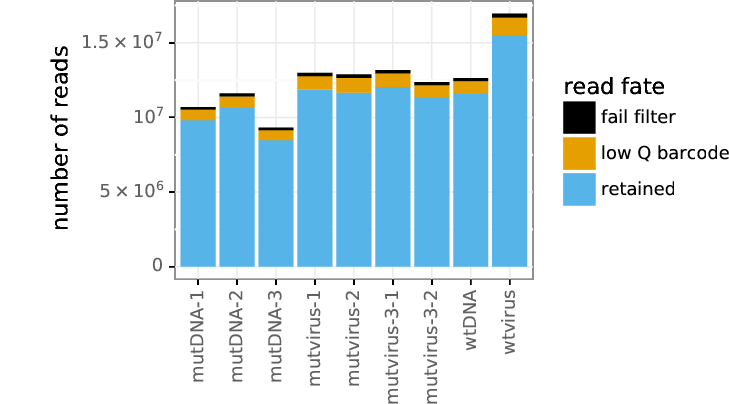

In [7]:
showPDF(countsplotprefix + '_readstats.pdf', width=500)

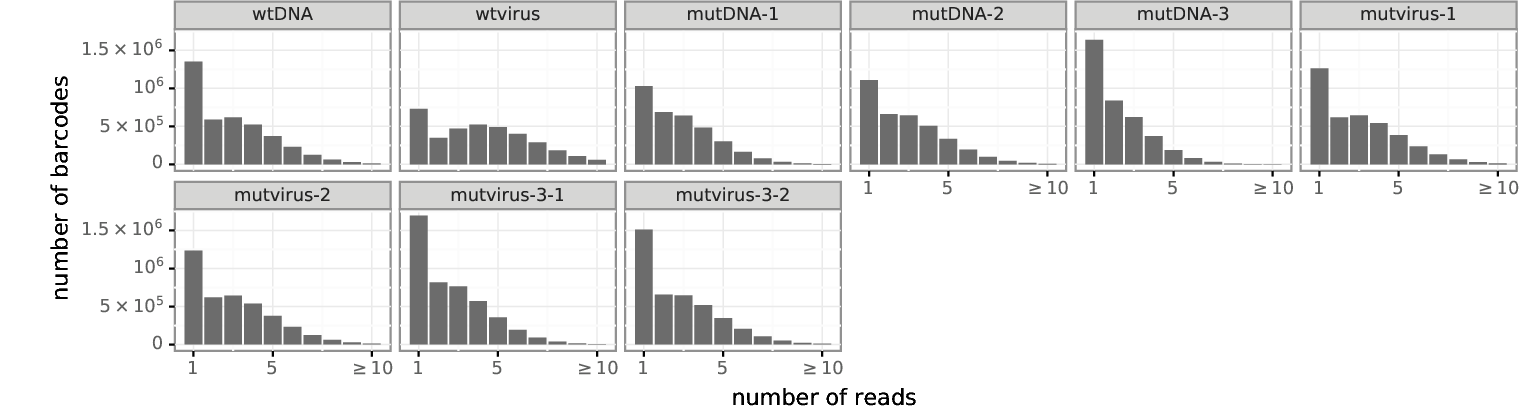

In [8]:
showPDF(countsplotprefix + '_readsperbc.pdf')

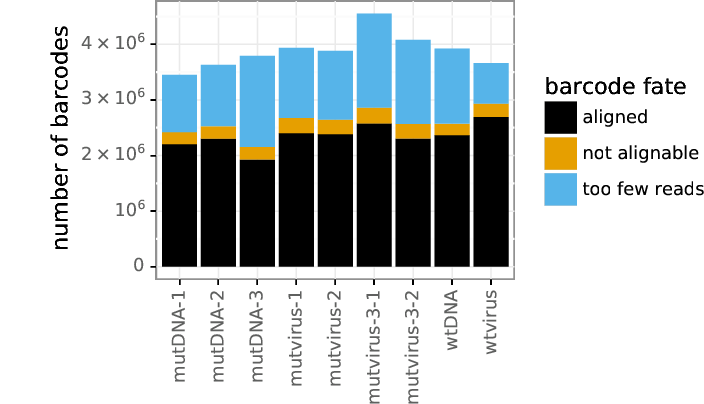

In [9]:
showPDF(countsplotprefix + '_bcstats.pdf', width=500)

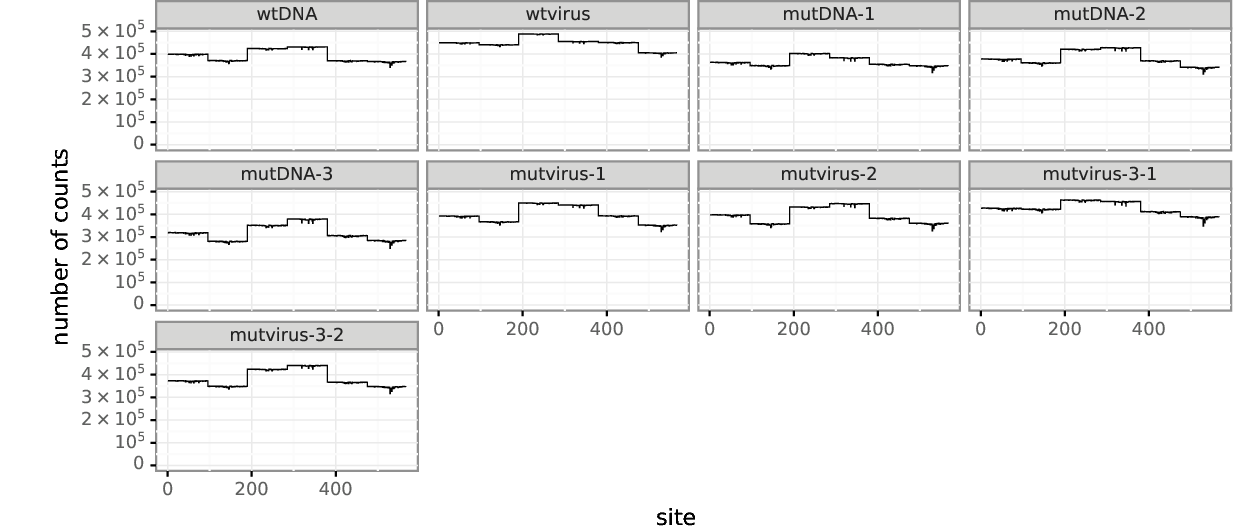

In [10]:
showPDF(countsplotprefix + '_depth.pdf')

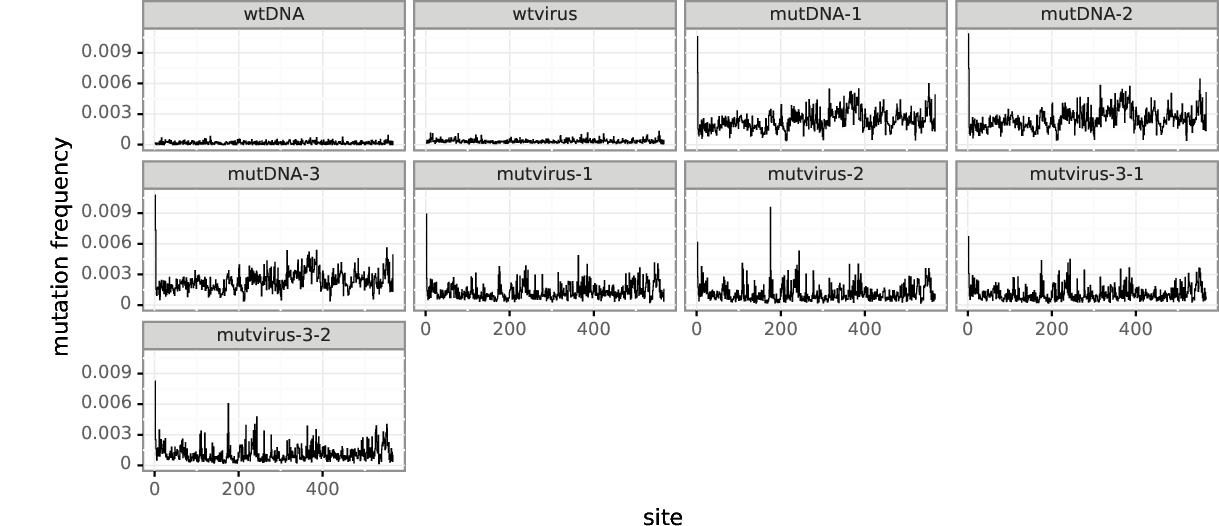

In [11]:
showPDF(countsplotprefix + '_mutfreq.pdf')

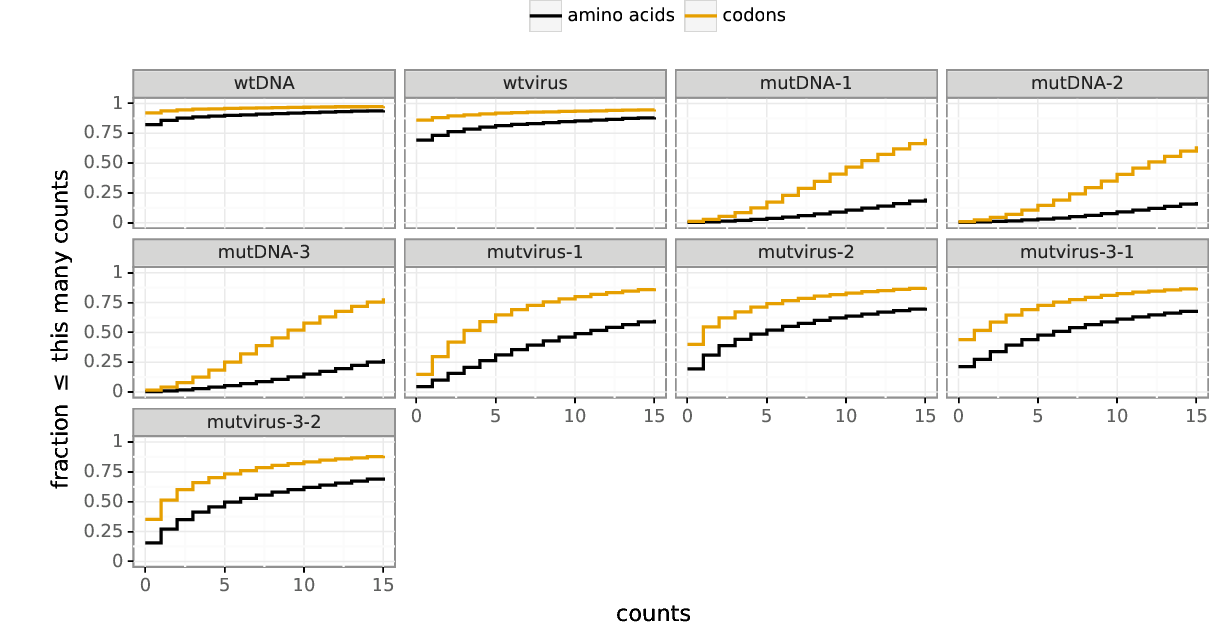

In [12]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

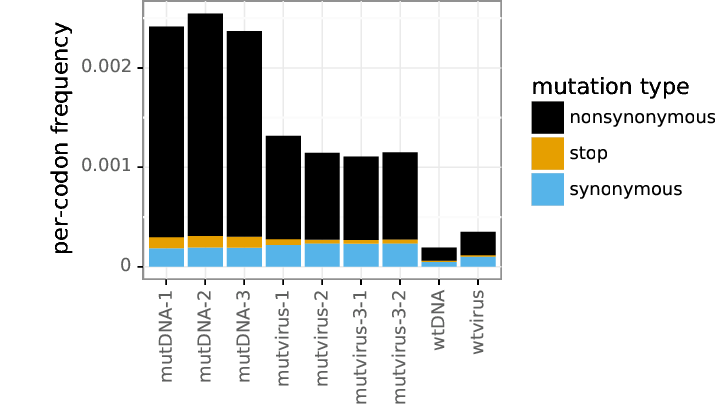

In [13]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=500)

In [14]:
codonmuttypes = pd.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
mutDNA-1,0.002118,0.000112,0.000186
mutDNA-2,0.002237,0.000117,0.000193
mutDNA-3,0.002068,0.000112,0.000191
mutvirus-1,0.001039,0.000059,0.000219
mutvirus-2,0.000875,0.000036,0.000235
mutvirus-3-1,0.000838,0.000039,0.000232
mutvirus-3-2,0.000876,0.000040,0.000235
wtDNA,0.000130,0.000015,0.000047
wtvirus,0.000233,0.000015,0.000102


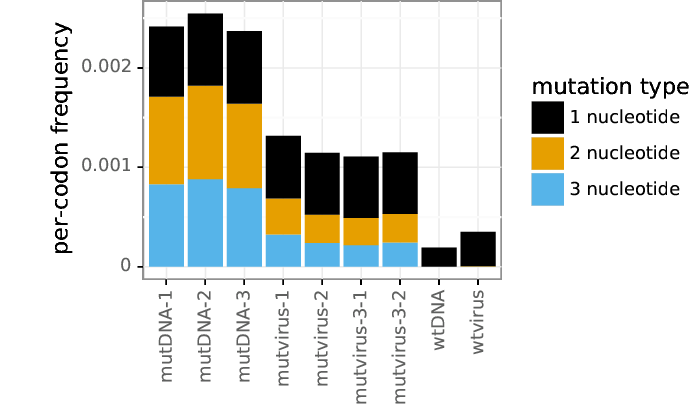

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=500)

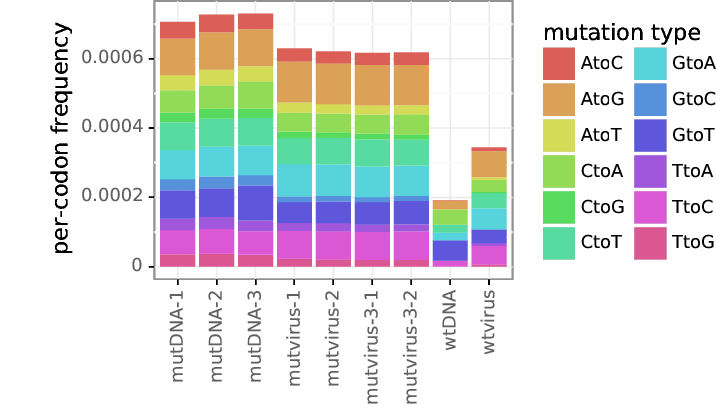

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=500)

# Infer the site-specific amino-acid preferences

In [7]:
# create batch file for dms2_batch_prefs
prefsbatch = pd.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('replicate-1', 'mutDNA-1', 'mutvirus-1', 'wtDNA', 'wtvirus'),
              ('replicate-2', 'mutDNA-2', 'mutvirus-2', 'wtDNA', 'wtvirus'),
              ('replicate-3-1', 'mutDNA-3', 'mutvirus-3-1', 'wtDNA', 'wtvirus'), 
              ('replicate-3-2', 'mutDNA-3', 'mutvirus-3-2', 'wtDNA', 'wtvirus')]
        )
prefsbatchfile = os.path.join(prefsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)

print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing} 
print("Completed running dms2_batch_prefs")

Here is the batch file that we write to CSV format to use as input:


name,pre,post,errpre,errpost
replicate-1,mutDNA-1,mutvirus-1,wtDNA,wtvirus
replicate-2,mutDNA-2,mutvirus-2,wtDNA,wtvirus
replicate-3-1,mutDNA-3,mutvirus-3-1,wtDNA,wtvirus
replicate-3-2,mutDNA-3,mutvirus-3-2,wtDNA,wtvirus


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


In [8]:
!ls {prefsdir}/*_prefs.csv

./results/preferences//replicate-1_prefs.csv
./results/preferences//replicate-2_prefs.csv
./results/preferences//replicate-3-1_prefs.csv
./results/preferences//replicate-3-2_prefs.csv


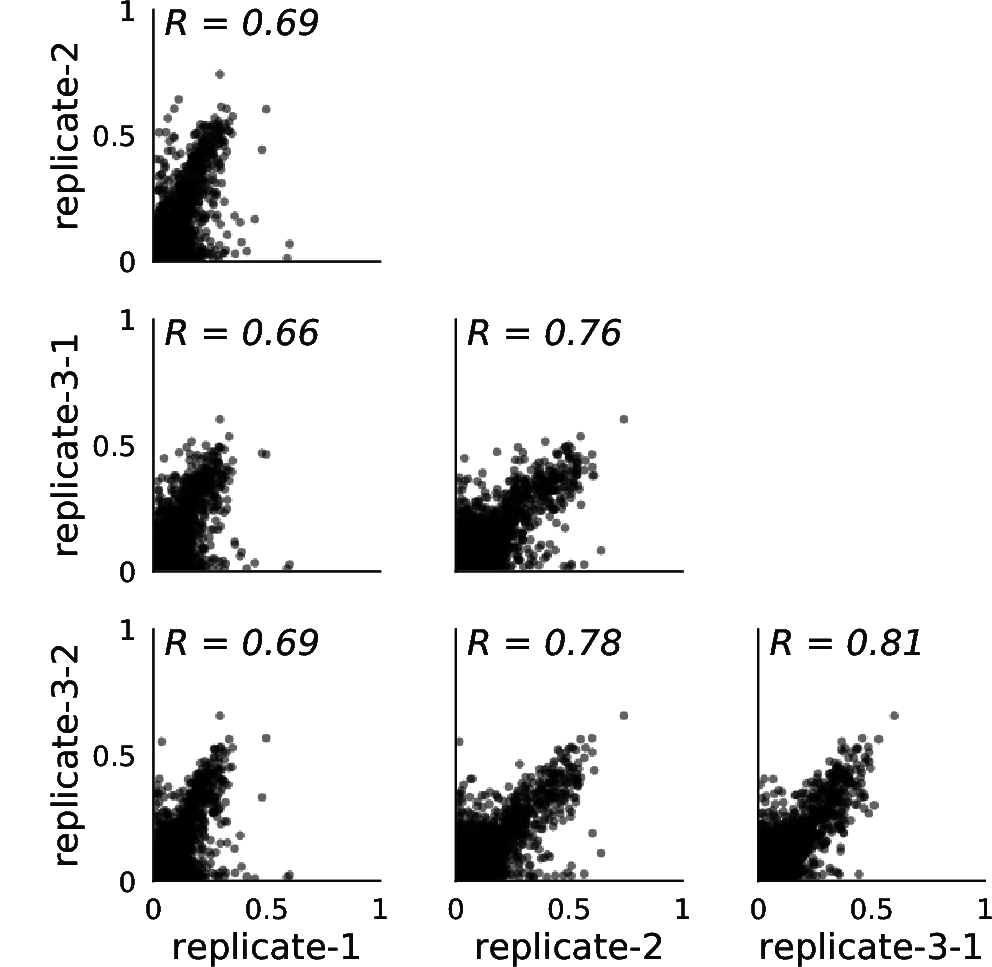

In [19]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'), width=300)

# Renumber preferences to H3 numbering

We will now renumber the preferences from sequential (1, 2, ... starting from the initial Met) to H3 numbering. 
The signal peptide is numbered with negative values, and the HA1 and HA2 subunits are numbered separately. 
This numbering scheme is based on an alignment to a PDB structure for an H3 HA [4HMG](https://www.rcsb.org/pdb/explore/explore.do?structureId=4HMG). 
We will use:
1. The [./data/H3renumbering_scheme.csv](./data/H3renumbering_scheme.csv) file to convert the sequential numbers into the H3 numbering scheme
2. The [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function to renumber the codon counts files

The renumbered files will be created in a new `renumberedprefs` directory and will possess the same names as the original preferences files created from `dms2_batch_bcsuabmp` above.

In [9]:
renumberfile = './data/H3renumbering_scheme.csv'

# preferences files to renumber
prefsfiles = glob.glob('{0}/*prefs.csv'.format(prefsdir))

dms_tools2.utils.renumberSites(renumberfile, prefsfiles, missing='drop', 
        outdir=renumberedprefsdir)

In [10]:
avgprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs.csv')
avgprefs_seqnum = os.path.join(prefsdir, 'summary_avgprefs.csv')

# Fit preferences to the evolution of natural H3 sequences

In [12]:
print("Using the following version of phydms:")
!phydms -v

raxmlpath = 'raxmlHPC-SSE3'
hosts = ['human', 'swine']

for host in hosts:
    alignment = './data/H3_{0}_alignment.fa'.format(host)
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(phydmsdir, host)
    if use_existing == 'yes' and os.path.isfile(modelcomparison):
        print('Results of phydms analysis for {0} alignment already exist.'.format(host))
    else:
        print('Running phydms_comprehensive...')
        outprefix = '{0}/{1}'.format(phydmsdir, host)
        log = !phydms_comprehensive {outprefix} {alignment} {avgprefs_seqnum} --raxml {raxmlpath} --omegabysite
        print('Analysis for {0} alignment complete.'.format(host))

Using the following version of phydms:
phydms 2.2.0
Results of phydms analysis for human alignment already exist.
Results of phydms analysis for swine alignment already exist.


In [13]:
for host in hosts:
    print('This is the model comparison using a {0} alignment:'.format(host))
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(phydmsdir, host)
    display(Markdown(modelcomparison))

This is the model comparison using a human alignment:


| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -8439.33      | 6       | beta=2.44, kappa=5.78, omega=0.91             |
| YNGKP_M5                        | 2166.06  | -9516.36      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_summary_avgprefs | 2504.18  | -9691.42      | 6       | beta=0.68, kappa=5.58, omega=0.32             |
| YNGKP_M0                        | 2607.92  | -9738.29      | 11      | kappa=5.05, omega=0.31                        |

This is the model comparison using a swine alignment:


| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -9042.21      | 6       | beta=2.38, kappa=6.05, omega=0.72             |
| YNGKP_M5                        | 2387.82  | -10230.12     | 12      | alpha_omega=0.35, beta_omega=1.30, kappa=5.26 |
| averaged_ExpCM_summary_avgprefs | 2702.52  | -10393.47     | 6       | beta=0.71, kappa=5.73, omega=0.25             |
| YNGKP_M0                        | 2864.72  | -10469.57     | 11      | kappa=5.12, omega=0.24                        |

## Display preferences as a rescaled logoplot

I will use the rescaling parameter ( $\beta$ ) from `phydms_comprehensive` to create logoplots of rescaled preferences.
First, I will read in the beta values from the `ExpCM *_modelparams.txt` file.

In [14]:
params_file = open('{0}/human_ExpCM_summary_avgprefs_modelparams.txt'.format(phydmsdir), 'r')
params_lst = [line.rstrip() for line in params_file.readlines()]
params_file.close()
beta = float([line for line in params_lst if 'beta' in line][0][7:])
print ('The beta parameter for the ExpCM for the averaged preferences = {0}'.format(beta))

The beta parameter for the ExpCM for the averaged preferences = 2.43599


Before making the logoplot, I will also create a new rescaled preferences file.

In [15]:
unscaled_prefsdf = pd.read_csv(avgprefs)
rescaled_prefsdf = dms_tools2.prefs.rescalePrefs(unscaled_prefsdf, beta)

rescaledavgprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs_rescaled.csv')
rescaled_prefsdf.to_csv(rescaledavgprefs, index=False)

In [16]:
dsspfile = './data/4O5N_trimer.dssp'

# Need to read in chain A (HA1) and chain B (HA2) separately, then concatenate into a single dataframe
HA1dssp_df = dms_tools2.dssp.processDSSP(dsspfile, chain='A')
# HA1sites = [x + 16 for x in HA1dssp_df['site'].tolist()]
# HA1dssp_df['site'] = HA1sites

HA2dssp_df = dms_tools2.dssp.processDSSP(dsspfile, chain='B')
HA2sites = ['(HA2)'+ str(x) for x in HA2dssp_df['site'].tolist()]
HA2dssp_df['site'] = HA2sites

dssp_df = pd.concat([HA1dssp_df, HA2dssp_df])
dssp_df['SS'] = dssp_df['SS_class']
ssfile = os.path.join(renumberedprefsdir, 'SS.csv')
dssp_df[['site', 'SS']].to_csv(ssfile, index=False)
rsafile = os.path.join(renumberedprefsdir, 'RSA.csv')
dssp_df[['site', 'RSA']].to_csv(rsafile, index=False)

In [17]:
seq_wtoverlayfile = os.path.join(prefsdir, 'wildtypeoverlayfile.csv')
aacounts = dms_tools2.utils.codonToAACounts(
        pd.read_csv(os.path.join(countsdir, 'wtDNA_codoncounts.csv')))
aacounts.query('wildtype != "*"')[['site', 'wildtype']].to_csv(seq_wtoverlayfile, index=False)

wtoverlayfile = os.path.join(renumberedprefsdir, 'wildtypeoverlayfile.csv')

dms_tools2.utils.renumberSites(renumberfile, [seq_wtoverlayfile], missing='drop', outdir=renumberedprefsdir)

Next, I will use the stringency parameters ( $\beta$ ) to make rescaled logoplots by specifying the `'--stringency'` argument.

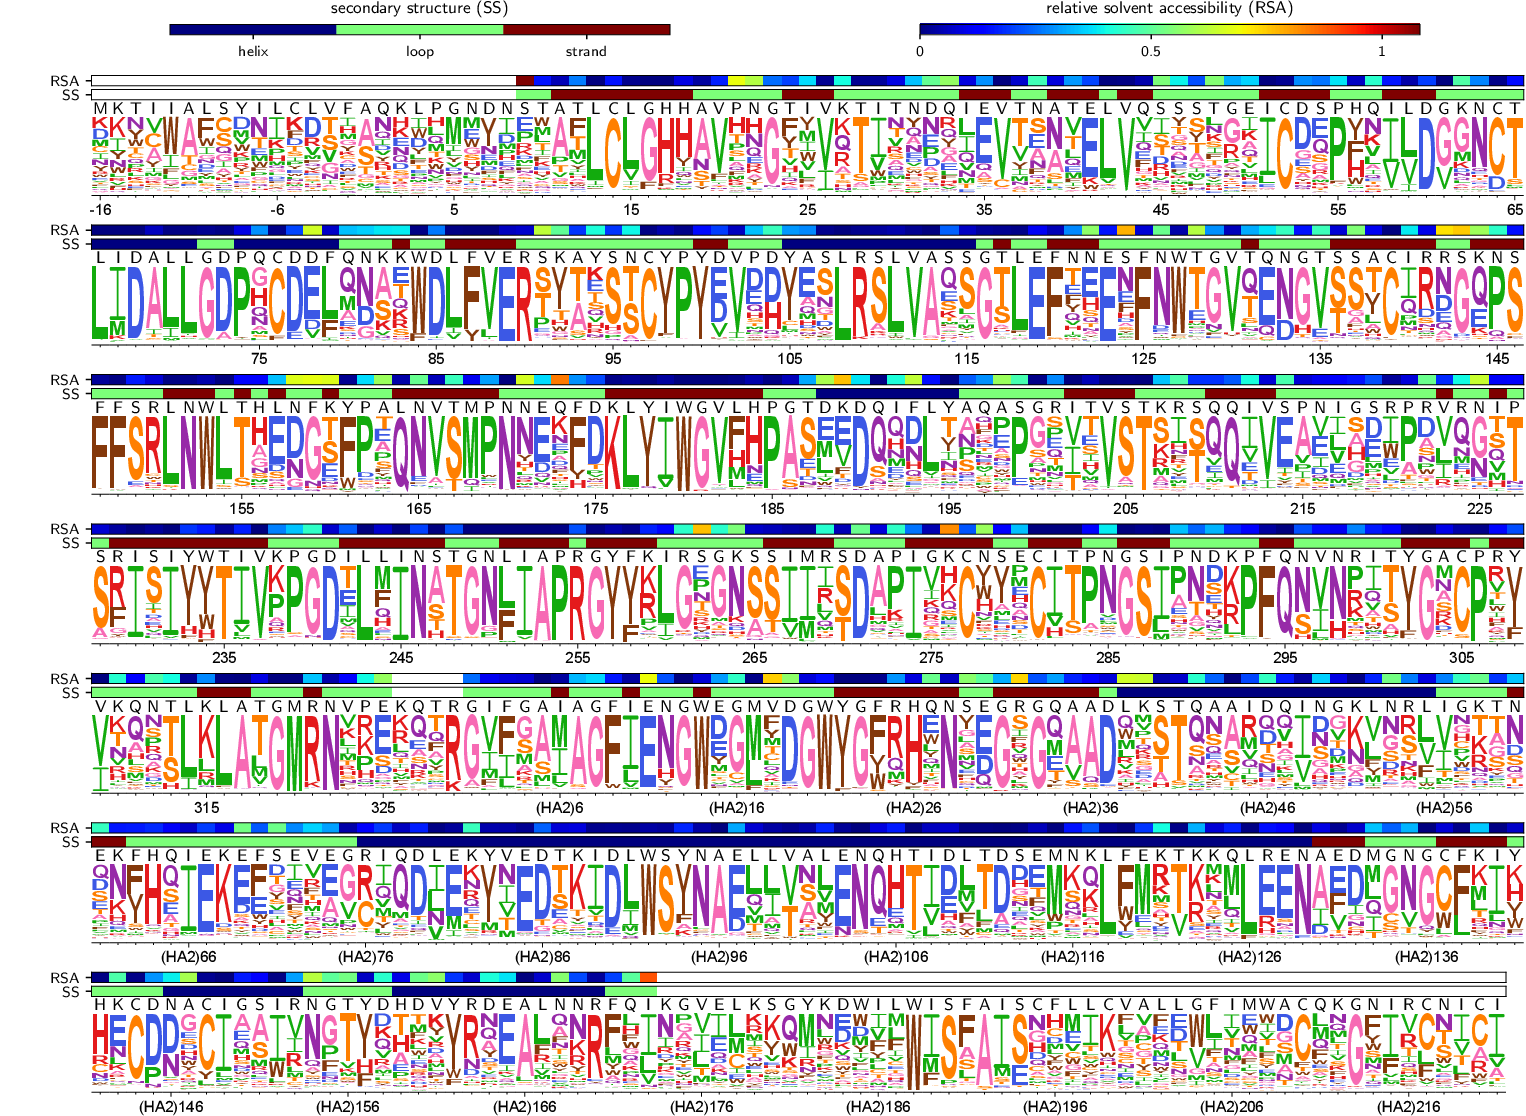

In [21]:
rescaledlogoname = 'rescaled-avgprefs'

log = !dms2_logoplot \
        --prefs {rescaledavgprefs} \
        --name {rescaledlogoname} \
        --outdir {logodir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {ssfile} SS "secondary structure" \
        --overlay3 {rsafile} RSA "relative solvent accessibility" \
        --nperline 81 \
        --use_existing {use_existing}
        
rescaledlogoplot = os.path.join(logodir, '{0}_prefs.pdf'.format(rescaledlogoname))
showPDF(rescaledlogoplot)

## Calculate the site entropy and write to a new preferences file

In [22]:
entropy_prefsdf = dms_tools2.prefs.prefsEntropy(rescaled_prefsdf, dms_tools2.AAS)

entropyprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs_rescaled_entropies.csv')
entropy_prefsdf.to_csv(entropyprefs, index=False)

# Section 2: Investigate lineage-specific mutational effects from H3N2 evolution

### Define a function to convert a `JSON` dictionary into a `Bio.Phylo` tree
Here I will use the complete H3N2 phylogeny from 1968-present, kindly provided by John Huddleston, which he prepared by using Trevor's nextstrain pipeline (`fauna` and `augur`). 
We will use this phylogeny to collect trunk and side branch mutations and calculate the mutational effects on both sets of branches.

In [37]:
def json_to_tree(json_dict):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.
    >>> import json
    >>> json_fh = open("tests/data/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.name = json_dict["strain"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child) for child in json_dict["children"]]

    # Assign all non-children attributes.
    for attr, value in json_dict.iteritems():
        if attr != "children":
            setattr(node, attr, value)

    return node